In [1]:
import os
import cv2
import base64
import re

from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import (
    BaseMessage,
    AIMessage,
    HumanMessage,
    ToolMessage,
)
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, InjectedState
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver

from datetime import datetime
from functools import partial
from dotenv import dotenv_values
from pyprojroot import here
from motor_control import StepperMotorController
from pathlib import Path
from typing import Annotated, Sequence
from typing_extensions import TypedDict

In [2]:
# Utils
def setup_run_folder(base_path):
    """
    Set up organized run folder structure.

    Args:
        base_path (str or Path): Base directory for all runs

    Returns:
        Path: The created run folder path
    """
    base_path = Path(base_path)

    # If base path doesn't exist, create run_1
    if not base_path.exists():
        run_path = base_path / "run_1"
        run_path.mkdir(parents=True, exist_ok=True)
        print(f"Created base directory and first run: {run_path}")
        return run_path

    # Find existing run folders
    existing_runs = []
    run_pattern = re.compile(r"^run_(\d+)$")

    for item in base_path.iterdir():
        if item.is_dir():
            match = run_pattern.match(item.name)
            if match:
                run_number = int(match.group(1))
                existing_runs.append(run_number)

    # Determine next run number
    if existing_runs:
        next_run = max(existing_runs) + 1
    else:
        next_run = 1

    # Create new run folder
    run_path = base_path / f"run_{next_run}"
    run_path.mkdir(parents=True, exist_ok=True)
    print(f"Created new run folder: {run_path}")

    return run_path


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[Sequence[BaseMessage], add_messages]

    # Microscope positioning and control
    current_z_position: int  # Current Z-axis position (0-4000)
    target_z_position: int  # Target Z-axis position for optimal focus

    # Focus quality tracking
    focus_quality_score: float  # Current focus quality (0.0-1.0)
    best_focus_score: float  # Best focus score achieved so far
    best_focus_position: int  # Z-position where best focus was achieved

    # Movement and adjustment history
    adjustment_history: Annotated[
        list[dict], lambda x, y: x + y
    ]  # Track all adjustments made
    focus_trend: str  # "improving", "declining", "stagnant"

    # Image management
    current_image_path: str  # Path to most recent captured image
    reference_image_path: str  # Path to reference/optimal focus image
    captured_images: Annotated[
        list[str], lambda x, y: x + y
    ]  # All captured image paths

    # Control flow and coordination
    next: str  # The 'next' field indicates where to route to next
    sender: str  # Which agent sent the last message

    # Error handling and system state
    last_error: str  # Last error encountered
    system_status: str  # "idle", "focusing", "capturing", "error"

    # Session and run information
    run_folder: str  # Current run folder path
    session_start_time: str  # When the focusing session started
    total_adjustments: int  # Total number of adjustments made this session

In [3]:
# Initialization
## API KEY
env_values = dotenv_values(".env")
os.environ["GROQ_API_KEY"] = env_values["GROQ_API_KEY"]

## Base chatbot
llm = init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct")

## Stepper motor controller
controller = StepperMotorController("COM16")
controller.connect()

## Image folder
BASE_PATH = here() / "outputs/images/"
RUN_PATH = setup_run_folder(BASE_PATH)
print(f"Images will be saved to: {RUN_PATH}")


def initialize_state() -> dict:
    """Initialize the microscope system state with default values."""
    return {
        "current_z_position": 0,
        "target_z_position": 2000,  # Default middle position
        "focus_quality_score": 0.0,
        "best_focus_score": 0.0,
        "best_focus_position": 0,
        "adjustment_history": [],
        "focus_trend": "unknown",
        "current_image_path": "",
        "reference_image_path": "",
        "captured_images": [],
        "next": "",
        "sender": "",
        "last_error": "",
        "system_status": "idle",
        "run_folder": str(RUN_PATH),
        "session_start_time": datetime.now().isoformat(),
        "total_adjustments": 0,
        "messages": [],
    }

Connected to Arduino on COM16
Created new run folder: d:\D\py4e\Summer_Research\outputs\images\run_1
Images will be saved to: d:\D\py4e\Summer_Research\outputs\images\run_1


In [4]:
@tool
def Change_Position(
    steps: int,
    state: Annotated[State, InjectedState],
) -> Command:
    """
    Change the Z-axis position of the microscope by moving the stepper motor.
    This tool now uses modern LangGraph patterns with state injection and Command returns.

    Args:
        steps (int): Number of steps to move. Positive values move closer to the sample
        (motor turns left). Negative values move away from sample (motor turns right).
        Range: -4000 to +4000. Minimum absolute step size is 10.
        state: Injected graph state

    Returns:
        Command: Contains both state updates and tool message
    """
    try:
        current_pos = state.get("current_z_position", 0)

        # Input validation
        if abs(steps) < 10 and steps != 0:
            error_msg = (
                f"Step size {steps} is below minimum of 10. No movement performed."
            )
            return Command(
                update={
                    "last_error": error_msg,
                    "system_status": "error",
                    "messages": [
                        ToolMessage(
                            content=error_msg, tool_call_id="change_position_error"
                        )
                    ],
                }
            )

        if steps == 0:
            success_msg = "No movement requested (0 steps)."
            return Command(
                update={
                    "messages": [
                        ToolMessage(
                            content=success_msg, tool_call_id="change_position_success"
                        )
                    ]
                }
            )

        # Calculate new position with bounds checking
        new_position = current_pos + steps
        actual_steps = steps

        if new_position < 0:
            actual_steps = -current_pos
            new_position = 0
        elif new_position > 4000:
            actual_steps = 4000 - current_pos
            new_position = 4000

        # Execute movement
        if actual_steps < 0:
            controller.move_motor("right", abs(actual_steps))
        else:
            controller.move_motor("left", actual_steps)

        # Update position tracking on controller
        if hasattr(controller, "current_position"):
            controller.current_position = new_position

        # Create comprehensive state update
        adjustment_record = {
            "timestamp": datetime.now().isoformat(),
            "steps_requested": steps,
            "steps_actual": actual_steps,
            "position_before": current_pos,
            "position_after": new_position,
            "status": "success" if actual_steps == steps else "partial",
        }

        success_msg = (
            f"Moved {actual_steps} steps. Position: {current_pos} → {new_position}"
        )

        return Command(
            update={
                "current_z_position": new_position,
                "adjustment_history": [adjustment_record],
                "total_adjustments": state.get("total_adjustments", 0) + 1,
                "system_status": "idle",
                "last_error": "",
                "messages": [
                    ToolMessage(
                        content=success_msg, tool_call_id="change_position_success"
                    )
                ],
            }
        )

    except Exception as e:
        error_msg = f"Motor control failed: {str(e)}"
        return Command(
            update={
                "last_error": error_msg,
                "system_status": "error",
                "messages": [
                    ToolMessage(content=error_msg, tool_call_id="change_position_error")
                ],
            }
        )


@tool
def Capture_Image(
    camera_index: int = 2,
    state: Annotated[State, InjectedState] = None,
) -> Command:
    """
    Capture an image from the USB microscope (webcam) with enhanced state management.

    Args:
        camera_index: Camera device index (usually 0 for default camera)
        state: Injected graph state

    Returns:
        Command: Contains state updates with image information
    """
    try:
        cap = cv2.VideoCapture(camera_index)
        if not cap.isOpened():
            error_msg = "Could not open camera"
            return Command(
                update={
                    "last_error": error_msg,
                    "system_status": "error",
                    "messages": [
                        ToolMessage(content=error_msg, tool_call_id="capture_error")
                    ],
                }
            )

        # Set the correct camera properties
        cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        cap.set(cv2.CAP_PROP_AUTOFOCUS, 0)

        # Capture frame
        ret, frame = cap.read()
        cap.release()

        if not ret:
            error_msg = "Failed to capture image"
            return Command(
                update={
                    "last_error": error_msg,
                    "system_status": "error",
                    "messages": [
                        ToolMessage(content=error_msg, tool_call_id="capture_error")
                    ],
                }
            )

        # Generate timestamped filename with position info
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        current_pos = state.get("current_z_position", 0) if state else 0
        filename = f"microscope_z{current_pos}_{timestamp}.jpg"
        save_path = RUN_PATH / filename
        cv2.imwrite(str(save_path), frame)

        success_msg = f"Image captured: {filename} at Z-position {current_pos}"

        return Command(
            update={
                "current_image_path": str(save_path),
                "captured_images": [str(save_path)],
                "system_status": "idle",
                "last_error": "",
                "messages": [
                    ToolMessage(content=success_msg, tool_call_id="capture_success")
                ],
            }
        )

    except Exception as e:
        error_msg = f"Capture failed: {str(e)}"
        return Command(
            update={
                "last_error": error_msg,
                "system_status": "error",
                "messages": [
                    ToolMessage(content=error_msg, tool_call_id="capture_error")
                ],
            }
        )


@tool
def Recommend_Steps(
    state: Annotated[State, InjectedState],
    reference_image_path: str = None,
) -> Command:
    """
    Analyze microscope image and recommend Z-axis positioning steps using current state.

    Args:
        state: Injected graph state containing current image and position info
        reference_image_path: Optional override for reference image path

    Returns:
        Command: Step recommendations and updated focus analysis state
    """
    try:
        # Get current image path from state
        current_image_path = state.get("current_image_path")
        if not current_image_path:
            error_msg = "No current image available. Please capture an image first."
            return Command(
                update={
                    "last_error": error_msg,
                    "messages": [
                        ToolMessage(content=error_msg, tool_call_id="recommend_error")
                    ],
                }
            )

        # Use reference from state or provided parameter
        ref_path = reference_image_path or state.get("reference_image_path")
        current_z_position = state.get("current_z_position", 0)
        adjustment_history = state.get("adjustment_history", [])

        # Encode current image to base64
        with open(current_image_path, "rb") as image_file:
            current_base64 = base64.b64encode(image_file.read()).decode("utf-8")

        # Prepare messages for the model
        messages = []

        # Add reference image if available
        if ref_path and os.path.exists(ref_path):
            with open(ref_path, "rb") as ref_file:
                ref_base64 = base64.b64encode(ref_file.read()).decode("utf-8")

            messages.append(
                HumanMessage(
                    content=[
                        {
                            "type": "text",
                            "text": "REFERENCE IMAGE - Optimal focus quality standard:",
                        },
                        {
                            "type": "input_image",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{ref_base64}"
                            },
                        },
                    ]
                )
            )

        # Add adjustment history context for better decision making
        history_context = ""
        if adjustment_history:
            recent_adjustments = adjustment_history[-3:]  # Last 3 adjustments
            history_context = "\nRECENT ADJUSTMENT HISTORY:\n"
            for i, adj in enumerate(recent_adjustments, 1):
                history_context += f"{i}. Position {adj['position_before']} → {adj['position_after']} (steps: {adj['steps_actual']})\n"

        # Enhanced context message with state information
        context_message = f"""CURRENT MICROSCOPE STATUS:
- Z-position: {current_z_position}/4000
- Total adjustments this session: {state.get('total_adjustments', 0)}
- Best focus score achieved: {state.get('best_focus_score', 'unknown')}
- Best focus position: {state.get('best_focus_position', 'unknown')}
- Current focus trend: {state.get('focus_trend', 'unknown')}
{history_context}

ANALYSIS REQUEST:
1. Evaluate current image focus quality (0-100%)
2. Compare to reference if available
3. Recommend next adjustment considering history
4. Provide confidence level for recommendation

CURRENT IMAGE TO ANALYZE:"""

        messages.append(
            HumanMessage(
                content=[
                    {"type": "text", "text": context_message},
                    {
                        "type": "input_image",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{current_base64}"
                        },
                    },
                ]
            )
        )

        # Get recommendation from model
        response = llm.invoke(messages, config={"configurable": {"temperature": 0.1}})

        # Parse response for focus quality (simplified - you could make this more sophisticated)
        response_text = response.content

        # Simple focus quality extraction (enhance this based on your model's response format)
        focus_quality = 0.5  # Default
        if "focus quality" in response_text.lower():
            import re

            quality_match = re.search(r"(\d+(?:\.\d+)?)%", response_text)
            if quality_match:
                focus_quality = float(quality_match.group(1)) / 100.0

        # Update focus trend based on history
        best_score = state.get("best_focus_score", 0.0)
        trend = "unknown"
        if focus_quality > best_score:
            trend = "improving"
        elif len(adjustment_history) >= 2:
            # Compare with previous (simplified logic)
            trend = "declining" if focus_quality < best_score * 0.9 else "stagnant"

        success_msg = (
            f"Focus analysis complete. Quality: {focus_quality:.1%}, Trend: {trend}"
        )

        return Command(
            update={
                "focus_quality_score": focus_quality,
                "best_focus_score": max(focus_quality, best_score),
                "best_focus_position": (
                    current_z_position
                    if focus_quality > best_score
                    else state.get("best_focus_position", current_z_position)
                ),
                "focus_trend": trend,
                "system_status": "idle",
                "last_error": "",
                "messages": [
                    ToolMessage(
                        content=f"{success_msg}\n\n{response_text}",
                        tool_call_id="recommend_success",
                    )
                ],
            }
        )

    except Exception as e:
        error_msg = f"Step recommendation failed: {str(e)}"
        return Command(
            update={
                "last_error": error_msg,
                "system_status": "error",
                "messages": [
                    ToolMessage(content=error_msg, tool_call_id="recommend_error")
                ],
            }
        )

In [5]:
# System Prompts
MAIN_AGENT_PROMPT = """You are the main coordination agent for an automated microscope focusing system. 
Your role is to coordinate between the Control and Image agents to achieve optimal focus.

You have access to the following team members:
- Control_Agent: Handles microscope positioning and motor control
- Image_Agent: Captures and analyzes images, provides step recommendations

Based on the user's request, determine which agent should act next. When optimal focus is achieved, respond with FINISH.
"""

CONTROL_AGENT_PROMPT = """You are the microscope control agent responsible for Z-axis positioning.
You can move the microscope using the Change_Position tool.

IMPORTANT: 
- Z-axis range is 0-4000 steps
- Minimum step size is 10
- Positive steps move down, negative steps move up
- Current position cannot go below 0 or above 4000

Execute positioning commands accurately and report the results.
"""

IMAGE_AGENT_PROMPT = """You are the image analysis agent for microscope focusing.
You can capture images and analyze them for focus quality.

Use the following tools:
- Capture_Image: Take pictures from the microscope
- Recommend_Steps: Analyze images and provide step recommendations

ANALYSIS PROCESS:
1. Compare current image to reference image to determine focus quality
2. Track focus quality trajectory from previous adjustments  
3. Calculate optimal next step size/direction using adaptive strategy:
   - Initial coarse search: Large steps (1000-2000) when far from focus
   - Fine-tuning: Reduce step size by 50% when focus improves
   - Overshoot detection: Reverse direction with smaller steps (25%) if focus degrades
   - Convergence: 10 step precision when near optimal focus

RESPONSE FORMAT:
**Focus State:** 
- Quality: [% match to reference] 
- Trend: [Improving/Declining/Stagnant]
**Adjustment:** 
- Steps: [Number] (Size: [Coarse/Medium/Fine])
**Rationale:** [Pattern analysis from adjustments]
**Expected:** [Predicted focus improvement %]
"""


# Create Agent Functions
def create_agent(llm, tools, system_message: str):
    """Create an agent with tools."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_message),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, verbose=True)


def create_main_agent(llm, team_members: list):
    """Create the main coordination agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"{MAIN_AGENT_PROMPT}\nTeam members: {', '.join(team_members)}"),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    return prompt | llm


def agent_node(state: State, agent, name: str):
    """Generic agent node function."""
    result = agent.invoke({"messages": state["messages"]})

    if hasattr(result, "content"):
        # Direct model response
        return {
            "messages": [AIMessage(content=result.content, name=name)],
            "sender": name,
        }
    else:
        # AgentExecutor response
        return {
            "messages": [AIMessage(content=result["output"], name=name)],
            "sender": name,
        }


# Create specific agents
control_agent = create_agent(llm, [Change_Position], CONTROL_AGENT_PROMPT)
image_agent = create_agent(llm, [Capture_Image, Recommend_Steps], IMAGE_AGENT_PROMPT)
main_agent = create_main_agent(llm, ["Control_Agent", "Image_Agent"])

# Create agent nodes
control_node = partial(agent_node, agent=control_agent, name="Control_Agent")
image_node = partial(agent_node, agent=image_agent, name="Image_Agent")
main_node = partial(agent_node, agent=main_agent, name="Main_Agent")

# Create tool nodes
control_tools_node = ToolNode([Change_Position])
image_tools_node = ToolNode([Capture_Image, Recommend_Steps])

In [6]:
# Routing Functions
def should_continue(state: State):
    """Determine if agent should continue with tools or route to another agent."""
    messages = state["messages"]
    if not messages:
        return END

    last_message = messages[-1]

    # Check if there are tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "continue"

    # Check for routing keywords or errors
    if "NEED HELP" in last_message.content:
        return "route"
    elif "FINISH" in last_message.content:
        return END
    elif state.get("system_status") == "error":
        return "route"  # Route back to main agent for error handling

    return END


def main_routing(state: State):
    """Route from main agent to appropriate specialist with enhanced error handling."""
    messages = state["messages"]
    if not messages:
        return END

    last_message = messages[-1]

    # Check system status first
    if state.get("system_status") == "error":
        # Let main agent decide how to handle the error
        return END

    if "Control_Agent" in last_message.content:
        return "Control_Agent"
    elif "Image_Agent" in last_message.content:
        return "Image_Agent"
    else:
        return END


# Create the Graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("Main_Agent", main_node)
graph_builder.add_node("Control_Agent", control_node)
graph_builder.add_node("Image_Agent", image_node)
graph_builder.add_node("Control_Tools", control_tools_node)
graph_builder.add_node("Image_Tools", image_tools_node)

# Add edges
graph_builder.add_edge(START, "Main_Agent")

# Main agent routing
graph_builder.add_conditional_edges(
    "Main_Agent",
    main_routing,
    {"Control_Agent": "Control_Agent", "Image_Agent": "Image_Agent", END: END},
)

# Control agent flow
graph_builder.add_conditional_edges(
    "Control_Agent",
    should_continue,
    {"continue": "Control_Tools", "route": "Main_Agent", END: END},
)
graph_builder.add_edge("Control_Tools", "Control_Agent")

# Image agent flow
graph_builder.add_conditional_edges(
    "Image_Agent",
    should_continue,
    {"continue": "Image_Tools", "route": "Main_Agent", END: END},
)
graph_builder.add_edge("Image_Tools", "Image_Agent")

# Compile the graph with checkpointing
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

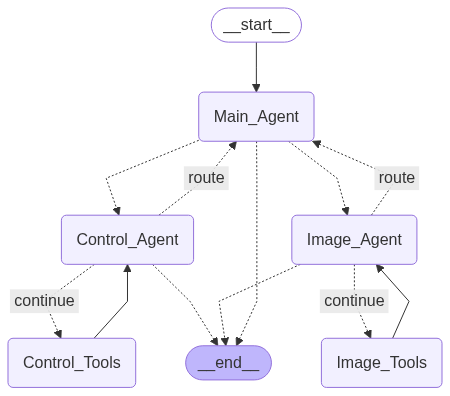

In [7]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# # Test the system with proper state initialization
initial_message = HumanMessage(
    content="Please capture an image and analyze the focus quality, then provide step recommendations for optimal focusing."
)

initial_state = initialize_state()
initial_state["messages"] = [initial_message]
initial_state["sender"] = "User"
initial_state["reference_image_path"] = str(here() / "assets/Tape/References.png")

config = {"recursion_limit": 50, "configurable": {"thread_id": "test_session_1"}}

print("Starting microscope focusing session...")
print(f"Initial state: {initial_state['system_status']}")
print(f"Run folder: {initial_state['run_folder']}")
print(f"Reference image: {initial_state['reference_image_path']}")
print("=" * 60)

for step in graph.stream(initial_state, config=config):
    print(step)
    print("---")

# Check final state
final_state = graph.get_state(config)
print("\n" + "=" * 60)
print("FINAL STATE SUMMARY:")
print(f"System Status: {final_state.values.get('system_status', 'unknown')}")
print(f"Current Z Position: {final_state.values.get('current_z_position', 'unknown')}")
print(
    f"Focus Quality Score: {final_state.values.get('focus_quality_score', 'unknown')}"
)
print(f"Total Adjustments: {final_state.values.get('total_adjustments', 'unknown')}")
print(f"Images Captured: {len(final_state.values.get('captured_images', []))}")
if final_state.values.get("last_error"):
    print(f"Last Error: {final_state.values.get('last_error')}")

Starting microscope focusing session...
Initial state: idle
Run folder: d:\D\py4e\Summer_Research\outputs\images\run_1
Reference image: d:\D\py4e\Summer_Research\assets\Tape\References.png
{'Main_Agent': {'messages': [AIMessage(content="Image_Agent should act next. I will instruct Image_Agent to capture an image and analyze the focus quality.\n\nImage_Agent, please capture an image and analyze the focus quality. Provide step recommendations for optimal focusing. \n\n(I will wait for Image_Agent's response to determine the next action)", additional_kwargs={}, response_metadata={}, name='Main_Agent', id='5ae69b3b-97a7-4b3e-a747-674cb462090e')], 'sender': 'Main_Agent'}}
---


> Entering new AgentExecutor chain...
{'Main_Agent': {'messages': [AIMessage(content="Image_Agent should act next. I will instruct Image_Agent to capture an image and analyze the focus quality.\n\nImage_Agent, please capture an image and analyze the focus quality. Provide step recommendations for optimal focusing. \n